The project uses a pretrained CNN model to extract features from the LFW dataset of images. A k-nearest-neighbours algorithm is used to determine which images in the data are most similar to an input image.

In [1]:
#Downloading all the libraries
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import tensorflow
import random
import numpy
from scipy.spatial import distance

In [2]:
# Downloading the dataset
!echo "Downloading lFW dataset"
!curl -L -o lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xzf lfw.tgz
!rm lfw.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  75.8M      0  0:00:02  0:00:02 --:--:-- 75.8M


CNN Model
We are using a ResNet50 CNN from Tensorflow Keras pretrained on images from the ImageNet database. The ResNet50 model is a residual convolutional neural network, meaning it uses 'residual blocks' to improve accuracy and prevent degredation (due to vanishing/exploding gradients or model performance) by utilizing skip connections. Skip connections enable the model to learn an identity function, ensuring accuracy across layers (regardless of how far down the gradient goes) and sets up shortcuts for the gradient to pass through (preventing its degredation). This means the model can include a large number of layers (in this case 50). The output of the CNN for each image is a one-dimensional array which is considered to be the embedded features of the image and is saved in an array.

In [3]:
# ResNet50 model
import tensorflow
model = tensorflow.keras.applications.ResNet50(weights='imagenet', include_top=True)

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
# Checking the layers in model
model.summary()

In [4]:
# Converting the image into numpy array
import numpy as np
import matplotlib.pyplot as plt

# Use a path to load and preprocess an image for feature-extraction
def image_numpy(path):
    image1 = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(image1)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return image1, img

shape of x:  (1, 224, 224, 3)
data type:  float32


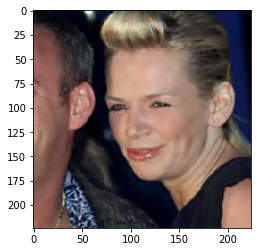

In [5]:
# Storing the shape of images 
image1, img = image_numpy("lfw/Zoe_Ball/Zoe_Ball_0001.jpg")
print("shape of x: ", img.shape)
print("data type: ", img.dtype)
plt.imshow(image1)

In [6]:
# model. predict() : given a trained model, predict the label of a new set of data
labels = model.predict(img)

In [7]:
labels = model(img)  # converts into  a tensorflow object
labels = labels.numpy()   # COnverts that tensorflow object into numpy array

In [8]:
# Removing the last "predictions" layer from the model
feature_array = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
feature_array.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
# Path of images in google colab
PathOfImage = 'lfw'
extension = ['.jpg', '.png', '.jpeg']  

In [10]:
images_arr = [os.path.join(dp, f) for dp, dn, filenames in os.walk(PathOfImage) for f in filenames if os.path.splitext(f)[1].lower() in extension]

# temprary so that I can run this a bit quicker while testing
# images_arr = images_arr[0:3000]

In [11]:
features = []
for i, PathOfImage in enumerate(images_arr):
    if i % 500 == 0:
        print("analyzing image %d: " % (i))
    image1, img = image_numpy(PathOfImage);
    j = feature_array.predict(img)[0]
    features.append(j)

print('finished extracting features for total images: ', len(images_arr))

analyzing image 0: 
analyzing image 500: 
analyzing image 1000: 
analyzing image 1500: 
analyzing image 2000: 
analyzing image 2500: 
finished extracting features for total images:  3000


KNN
The K-nearest-neighbours algorithm uses the euclidean distance between datapoints to determine the similarity between different data objects. The k 'nearest' objects are typically used to determine the 'class' of the input. In this case, the euclidean distance for the extracted features of images are calculauted and the 'closest' images to the input are returned.

The equation works as follows:

$ d(p, q_i) = \sqrt{\sum_{j=1}^{n} (q_{i_j} - p_j)^2} $

For all image embeddings $ q_0 ... q_n $ in features where n is the number of features returned by the CNN from the feature extraction step.

The results are mapped to the index of the image embedding in `features` and sorted from smallest to largest value for $ d(p, q_i) $. The first _output_size_ indices in the sorted array are returned as the results.


In [12]:
# Use Euclidean distance to find closest images.
def neighbours(input_image, features, output_size=6):
    '''
    input_image: index in features of image to search
    features: array of 'features' as determined by the CNN for every searchable image
    output_size: number of results returned
    returns: indices (?) of the n closest images based on euclidean distance where n is output_size
    '''
    euclid_distances = [ distance.euclidean(input_image, j) for j in features ]
    nn = sorted(range(len(euclid_distances)), key=lambda k: euclid_distances[k])
    nn = nn[1:output_size + 1] # leaving out image 0 since this should be the same as the input
    return nn

# Format and return images 
def output_nn(images, indexes, result_img_height):
    '''
    data: array of images
    indexes: indices of the images to format
    result_img_height: desired hieght of image
    returns: np array of formatted images
    '''
    result_img = []
    for i in indexes:
        image1 = image.load_img(images[i])
        image1 = image1.resize((int(image1.width * result_img_height / image1.height), result_img_height))
        result_img.append(image1)
    concat_image = np.concatenate([np.asarray(i) for i in result_img], axis=1)
    return concat_image

Time to find images in ms
For Elizabeth_Regan_0001.jpg: 1.059
For lfw/Steven_Tyler/Steven_Tyler_0001.jpg: 1.033


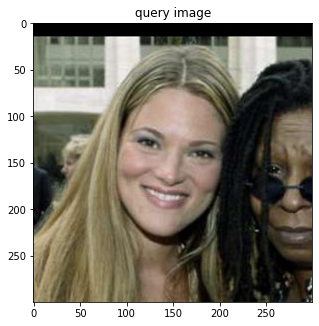

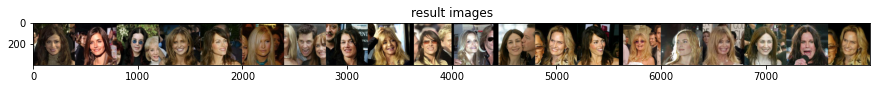

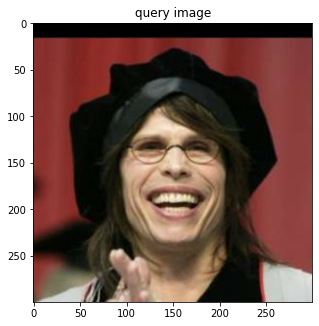

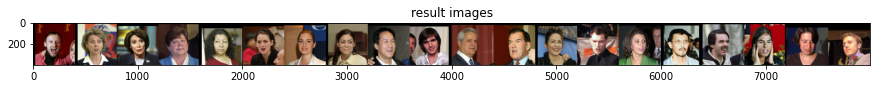

In [15]:
import time
# This funciton performs the search. The features array must be an array of the embedded
# features of images as determined by a CNN. Any dataset or model can be used 
# to extract this. The img_path is used to retrieve image data. The image data
# is put through the same CNN that was useed to extract the features array.
# The resulting embedding is used in the nearest neighbors algorithm along with
# the features array to determine the _output_size_ most-similar images.
def reverse_image_search(img_path, features, output_size=6):
  '''
  img_path: path to image to search
  features: array of 'features' as determined by the CNN for every searchable image
  output_size: number of results returned
  returns: array of formated data for n images with the smallest euclidean distance to img 
  based on on features extracted from the pretrained ResNet50 CNN model
  '''
  image1, img = image_numpy(img_path);
  j = feature_array.predict(img)[0]

  nn = neighbours(j, features, output_size)
  Input_images = output_nn([img_path], [0], 300)
  result_array = output_nn(images_arr, nn, 400)

  # display the query image
  plt.figure(figsize = (5,10))
  plt.imshow(Input_images)
  plt.title("query image")

  # display the resulting images
  plt.figure(figsize = (15,15))
  plt.imshow(result_array)
  plt.title("result images")

  return result_array

start = time.time()
reverse_image_search('lfw/Elizabeth_Regan/Elizabeth_Regan_0001.jpg', features, 20)
t = time.time()
time_passed1 = t - start
# Use a random image
path = images_arr[int(len(images_arr) * random.random())]
reverse_image_search(path, features, 20)
time_passed2 = time.time() - t
print('Time to find images in second')
print(f'For Elizabeth_Regan_0001.jpg: {round(time_passed1, 3)}')
print(f'For {path}: {round(time_passed2, 3)}')